# DATASET USED: https://www.kaggle.com/datasets/ppb00x/credit-risk-customers
**SOURCE: https://www.openml.org/search?type=data&sort=runs&status=active&id=31**

**License
CC BY 4.0**

**Code author: Andrei Ciprian Alexandru**

**URN: 6592956**

**Notebook created: 04/04/2023**

**Last update: 16/05/2023**

# ***Import the necessary libraries and load the data***

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from deap import base, creator, tools, algorithms
from torch.utils.data import random_split, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score
from graphviz import Digraph
import csv


# Load the data
data = pd.read_csv('/kaggle/input/credit-risk-customers/credit_customers.csv')

# Convert the categorical columns to dummy variables
data = pd.get_dummies(data, drop_first=True)

# ***Plot dataset analytics***

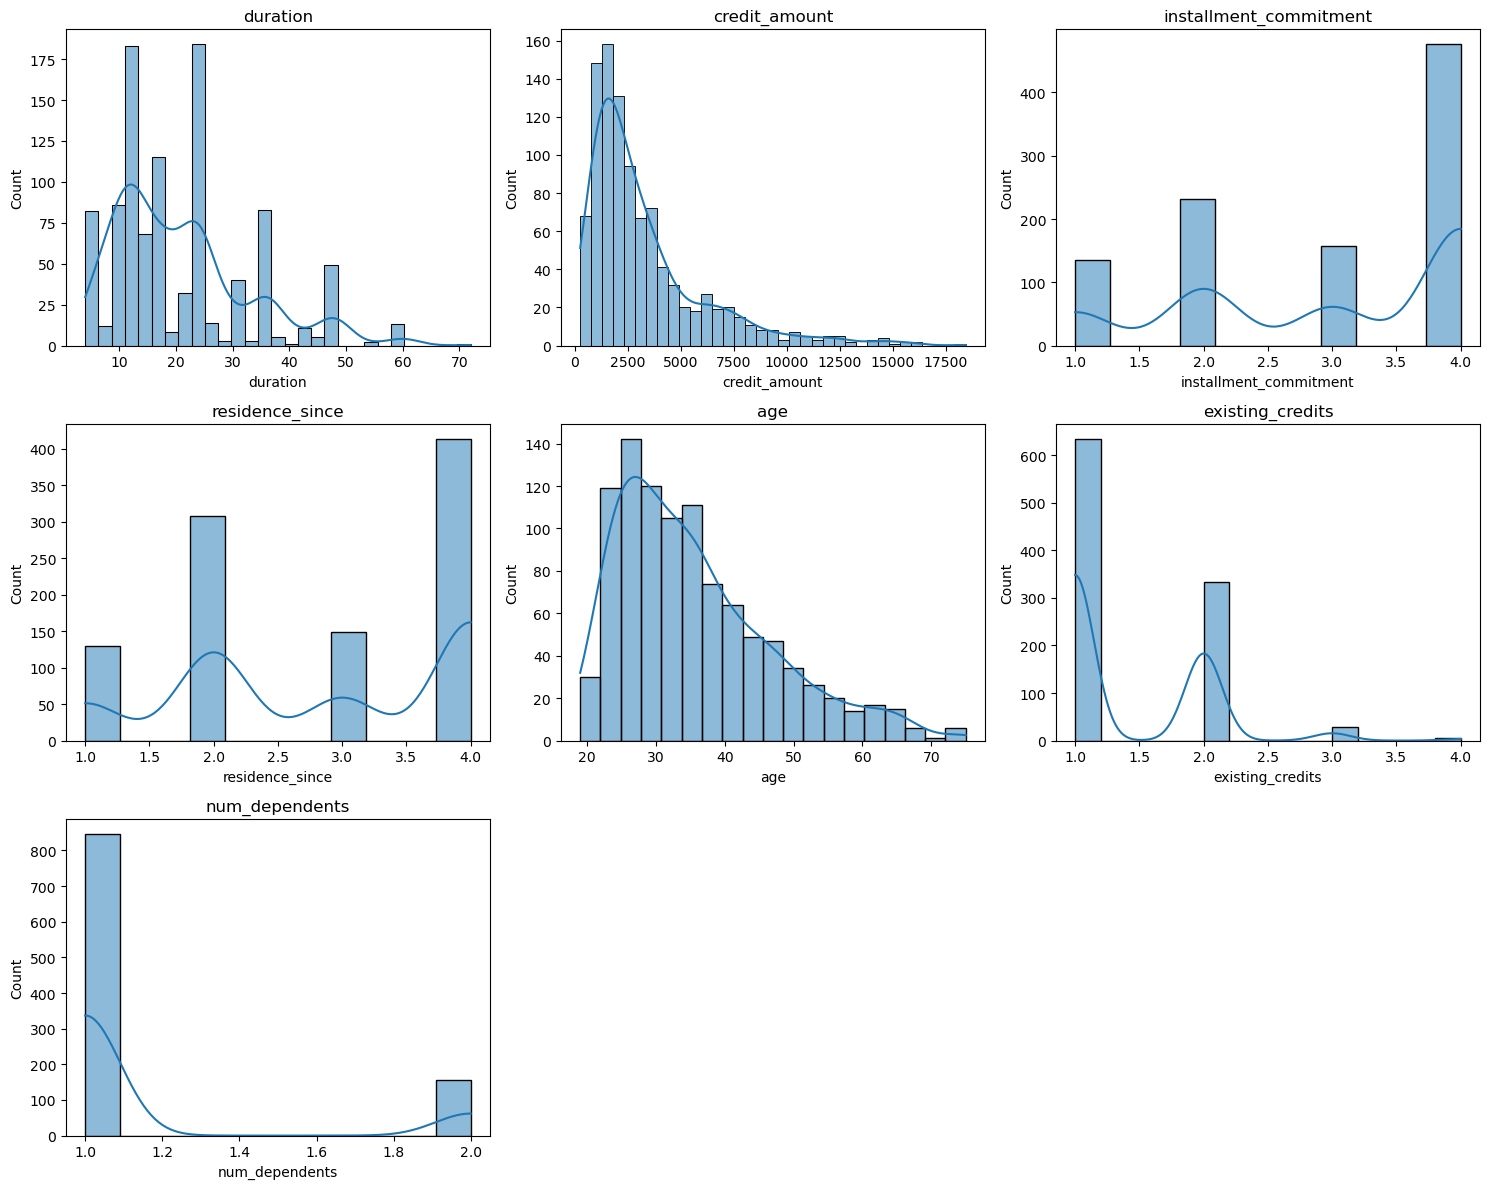

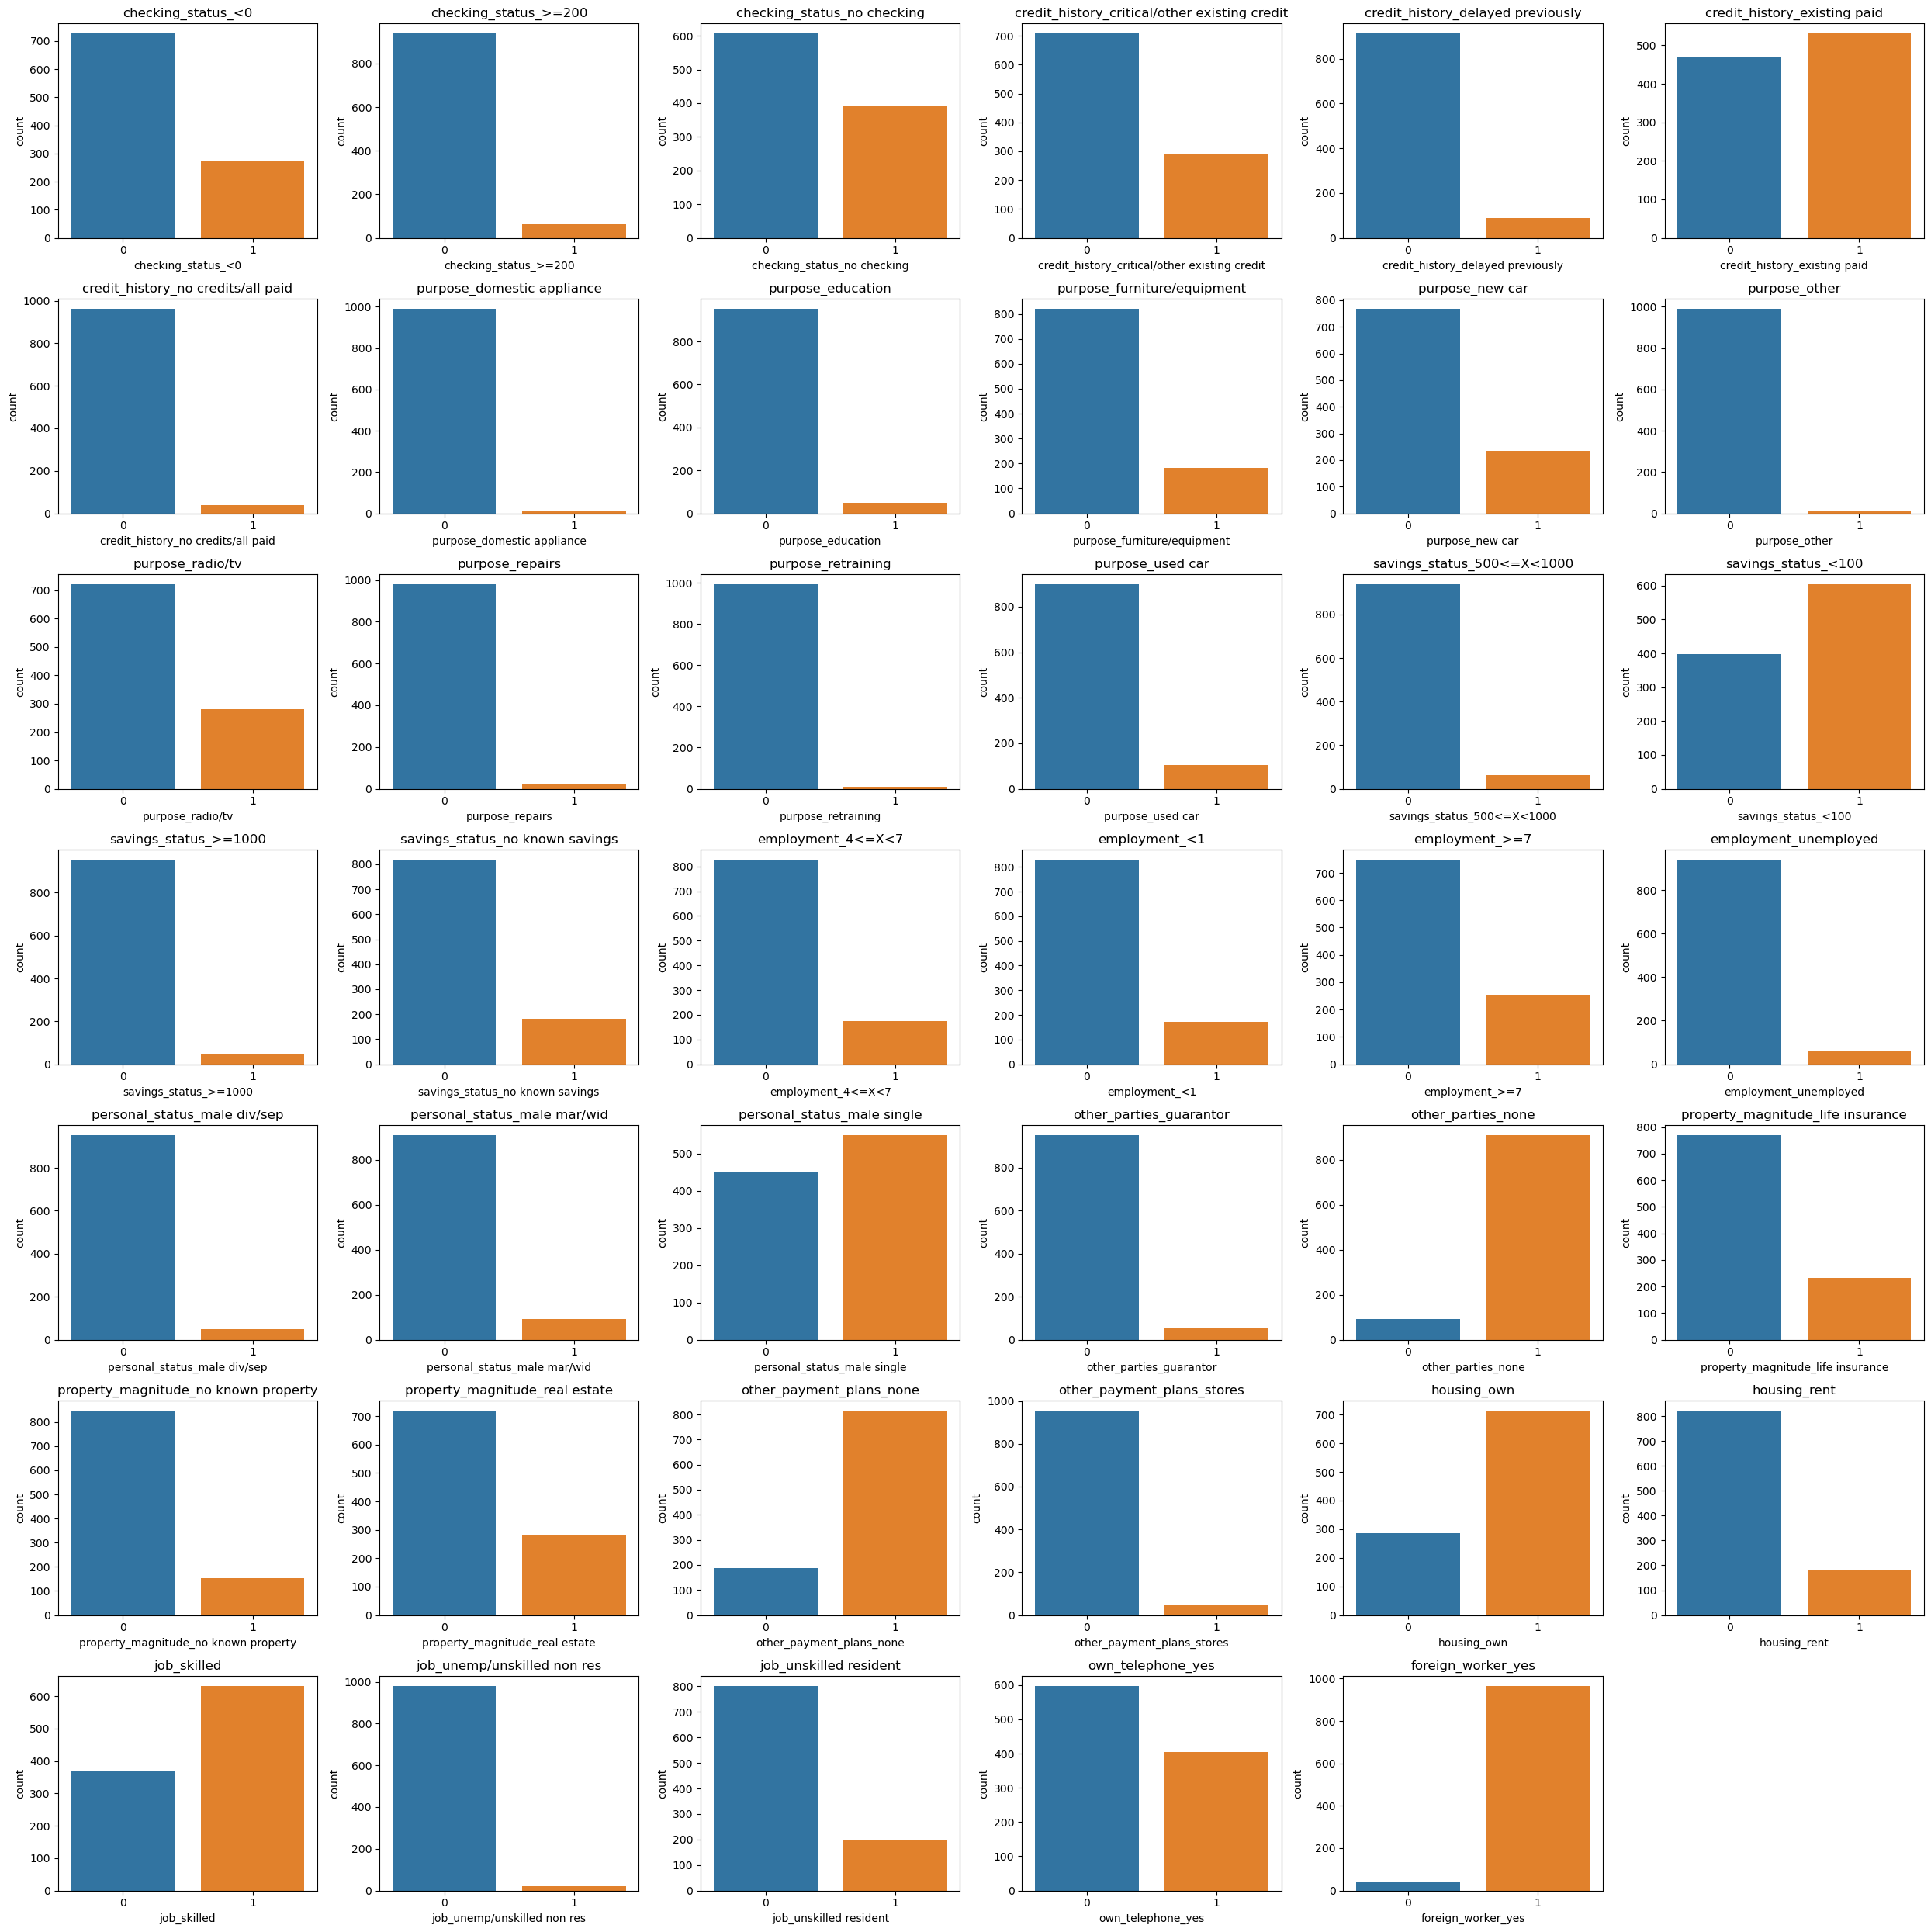

In [2]:
# Plot the histograms for numerical columns
numerical_columns = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))

for i, col in enumerate(numerical_columns):
    row, col_idx = divmod(i, n_cols)
    sns.histplot(data[col], ax=axes[row][col_idx], kde=True)
    axes[row][col_idx].set_title(col)

# Remove the extra subplots
for j in range(i+1, n_rows*n_cols):
    row, col_idx = divmod(j, n_cols)
    fig.delaxes(axes[row][col_idx])

plt.tight_layout()
plt.show()

# Plot the countplot for categorical columns
categorical_columns = [col for col in data.columns if col not in numerical_columns and col != 'class_good']
n_rows, n_cols = 7, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))

for i, col in enumerate(categorical_columns):
    row, col_idx = divmod(i, n_cols)
    sns.countplot(x=col, data=data, ax=axes[row][col_idx])
    axes[row][col_idx].set_title(col)

# Remove the extra subplots
for j in range(i+1, n_rows*n_cols):
    row, col_idx = divmod(j, n_cols)
    fig.delaxes(axes[row][col_idx])

plt.tight_layout()
plt.show()


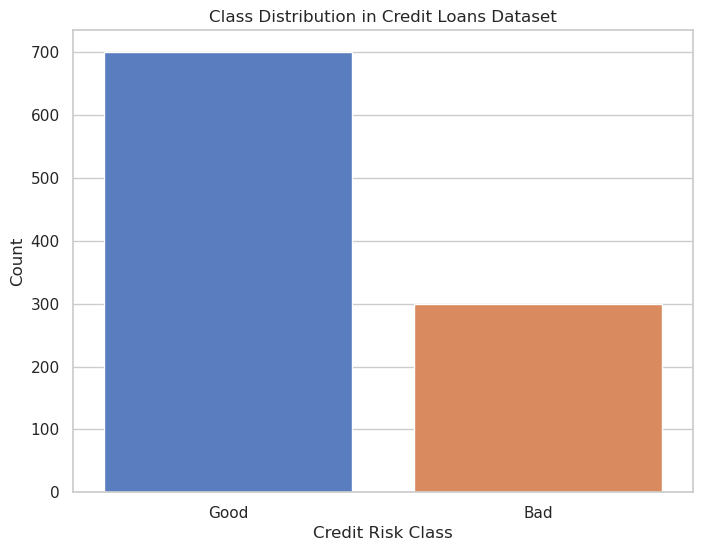

In [3]:
class_counts = data['class_good'].value_counts()
class_labels = ['Good', 'Bad']

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_counts, palette='muted')
plt.xlabel('Credit Risk Class')
plt.ylabel('Count')
plt.title('Class Distribution in Credit Loans Dataset')
plt.show()


# ***Create the data loaders***

In [4]:
batch_size = 128

# Calculate train and test sizes
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Split the data into train and test sets
train_data, test_data = random_split(data, [train_size, test_size])

# Define train_features, train_labels, test_features, and test_labels
train_features = train_data.dataset.iloc[train_data.indices, :-1].values
train_labels = train_data.dataset.iloc[train_data.indices, -1].values
test_features = test_data.dataset.iloc[test_data.indices, :-1].values
test_labels = test_data.dataset.iloc[test_data.indices, -1].values

# Scale the train and test features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Convert train and test features and labels into PyTorch tensors
train_features_tensor = torch.tensor(train_features_scaled, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features_scaled, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset and DataLoader for train and test sets
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ***Define the neural network then train it***

In [5]:
# Define the neural network architecture
class CreditNet(torch.nn.Module):
    def __init__(self):
        super(CreditNet, self).__init__()
        self.fc1 = torch.nn.Linear(train_features_scaled.shape[1], 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 32)
        self.fc4 = torch.nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the neural network
model = CreditNet()

# Set up the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

losses = []  # Store losses for each epoch

# Train the neural network
num_epochs = 25
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / (i + 1)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    
# Generate predictions for the entire dataset (to be used for training the decision tree)
with torch.no_grad():
    model_outputs = model(torch.tensor(train_features_scaled, dtype=torch.float32))
    _, model_predictions = torch.max(model_outputs.data, 1)

Epoch [1/25], Loss: 0.7090
Epoch [2/25], Loss: 0.6635
Epoch [3/25], Loss: 0.6280
Epoch [4/25], Loss: 0.6148
Epoch [5/25], Loss: 0.6092
Epoch [6/25], Loss: 0.5865
Epoch [7/25], Loss: 0.6018
Epoch [8/25], Loss: 0.5838
Epoch [9/25], Loss: 0.5920
Epoch [10/25], Loss: 0.5998
Epoch [11/25], Loss: 0.5832
Epoch [12/25], Loss: 0.5914
Epoch [13/25], Loss: 0.5858
Epoch [14/25], Loss: 0.5827
Epoch [15/25], Loss: 0.5642
Epoch [16/25], Loss: 0.5713
Epoch [17/25], Loss: 0.5577
Epoch [18/25], Loss: 0.5544
Epoch [19/25], Loss: 0.5556
Epoch [20/25], Loss: 0.5386
Epoch [21/25], Loss: 0.5271
Epoch [22/25], Loss: 0.5236
Epoch [23/25], Loss: 0.5188
Epoch [24/25], Loss: 0.4879
Epoch [25/25], Loss: 0.4959


# ***Plot the training loss***

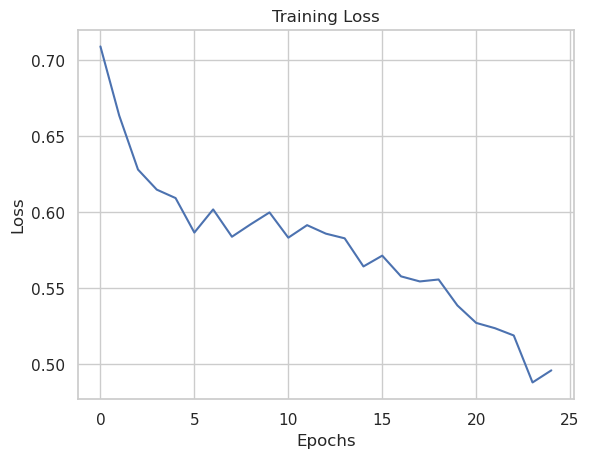

In [6]:
sns.set(style="whitegrid")

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


# ***Calculate the neural netwrok's accuracy on unseen data***

In [7]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return 100 * correct / total

# Test the neural network
model.eval()
test_accuracy_nn = calculate_accuracy(test_loader, model)
print(f'Test accuracy: {test_accuracy_nn:.2f}%')

Test accuracy: 66.00%


# ***Create, train and test the decision tree***

In [8]:
# Train a decision tree using the neural network's predictions as target values
UDt = DecisionTreeClassifier()
UDt.fit(train_features_scaled, model_predictions.numpy())

# Evaluate the decision tree
train_preds = UDt.predict(train_features_scaled)
test_preds = UDt.predict(test_features_scaled)

train_accuracy_unoptimized = accuracy_score(train_labels, train_preds)
test_accuracy_unoptimized = accuracy_score(test_labels, test_preds)

# Calculate the number of branches for the best individual
n_leaf_nodes = UDt.tree_.n_leaves
n_branches = n_leaf_nodes - 1

print(f"Max tree depth: {UDt.tree_.max_depth}")
print(f"Number of branches: {n_branches}")
print(f"Train accuracy: {train_accuracy_unoptimized * 100:.2f}%, Test accuracy: {test_accuracy_unoptimized * 100:.2f}%")

Max tree depth: 11
Number of branches: 45
Train accuracy: 75.12%, Test accuracy: 69.00%


# ***Plot the confusion matrix for the unoptimized decision tree***

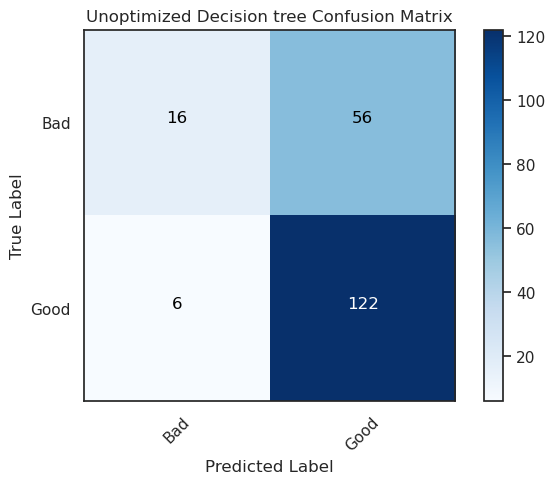

In [9]:
sns.set(style="white")

# Calculate the confusion matrix
test_predictions_unoptimized = UDt.predict(test_features_scaled)
cm_unoptimized = confusion_matrix(test_labels, test_predictions_unoptimized)

# Plot the confusion matrix
plt.figure()
plt.imshow(cm_unoptimized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Unoptimized Decision tree Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Bad', 'Good'], rotation=45)
plt.yticks(tick_marks, ['Bad', 'Good'])

import itertools
for i, j in itertools.product(range(cm_unoptimized.shape[0]), range(cm_unoptimized.shape[1])):
    plt.text(j, i, cm_unoptimized[i, j], horizontalalignment="center", color="white" if cm_unoptimized[i, j] > cm_unoptimized.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# ***Change variables for genetic algorithm here:***

In [10]:
threshold = 0.9  # Set a threshold for minimum improvement
patience = 30  # Set a patience level to allow some generations without improvement
population = 600 # Set the number of individuals per generation
generations = 100 # Set the number of maximum generations

# ***Define the genetic algorithm***

In [11]:
# Define genetic algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=train_features_scaled.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def fitness(individual, features, labels):
    mask = np.array(individual, dtype=bool)
    masked_features = features[:, mask]

    if masked_features.shape[1] == 0:
        return float('inf'),

    clf = DecisionTreeClassifier()
    clf.fit(masked_features, labels)

    score_depth = clf.tree_.max_depth
    n_leaf_nodes = clf.tree_.n_leaves
    score_width = n_leaf_nodes - 1

    score = score_depth + score_width
    return score,


toolbox.register("evaluate", fitness, features=train_features_scaled, labels=model_predictions.numpy())
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)

population = toolbox.population(n=population)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# ***Run the genetic algorithm and extract the best feature mask***
***Please note that the code contains early stopping so the genetic algorithm might not run for the full number of generations.***

***To deactivate the early stopping set the "patience" variable to the total number of generations, in the cell above.***

In [12]:
no_improv_counter = 0  # Initialize a counter for iterations without improvement
prev_best_fitness = None  # Initialize a variable to hold the best fitness from the previous iteration
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
cxpb = 0.6
mutpb = 0.5

# Run the genetic algorithm with early stopping
for gen in range(generations):  # Run for a maximum of n generations
    population = algorithms.varAnd(population, toolbox, cxpb=cxpb, mutpb=mutpb)  # Perform mating and mutation
    invalid_ind = [ind for ind in population if not ind.fitness.valid]  # Extract individuals with invalid fitness
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)  # Evaluate the individuals with an invalid fitness
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit  # Assign new fitness values to individuals

    # Update hall of fame and statistics
    hof.update(population)
    record = stats.compile(population)
    logbook.record(gen=gen, **record)

    # Print current generation and best fitness
    print("Generation: ", gen, ", Best Fitness: ", hof[0].fitness.values[0])

    # Check for improvement
    if prev_best_fitness is None or hof[0].fitness.values[0] < prev_best_fitness - threshold:
        no_improv_counter = 0  # Reset the counter
        prev_best_fitness = hof[0].fitness.values[0]  # Update the previous best fitness
        cxpb = cxpb - 0.2
        mutpb = mutpb - 0.2
    else:
        no_improv_counter += 1  # Increment the counter
        
    # Modify parameters
    if (no_improv_counter == patience/3 or no_improv_counter == patience - patience/3) and mutpb <= 0.7:
        print("Changing parameters to be more aggresive")
        cxpb = cxpb + 0.4
        mutpb = mutpb + 0.4
    
    # Early stopping
    if no_improv_counter >= patience:
        print("Stopping early due to lack of improvement.")
        break

# Extract the best individual (feature mask)
best_individual = hof[0]

Generation:  0 , Best Fitness:  58.0
Generation:  1 , Best Fitness:  58.0
Generation:  2 , Best Fitness:  57.0
Generation:  3 , Best Fitness:  57.0
Generation:  4 , Best Fitness:  55.0
Generation:  5 , Best Fitness:  55.0
Generation:  6 , Best Fitness:  55.0
Generation:  7 , Best Fitness:  55.0
Generation:  8 , Best Fitness:  55.0
Generation:  9 , Best Fitness:  55.0
Generation:  10 , Best Fitness:  55.0
Generation:  11 , Best Fitness:  55.0
Generation:  12 , Best Fitness:  55.0
Generation:  13 , Best Fitness:  55.0
Generation:  14 , Best Fitness:  55.0
Changing parameters to be more aggresive
Generation:  15 , Best Fitness:  55.0
Generation:  16 , Best Fitness:  55.0
Generation:  17 , Best Fitness:  55.0
Generation:  18 , Best Fitness:  55.0
Generation:  19 , Best Fitness:  55.0
Generation:  20 , Best Fitness:  55.0
Generation:  21 , Best Fitness:  55.0
Generation:  22 , Best Fitness:  55.0
Generation:  23 , Best Fitness:  55.0
Generation:  24 , Best Fitness:  55.0
Changing parameters

# ***Plot the genetic algorithm fitness***

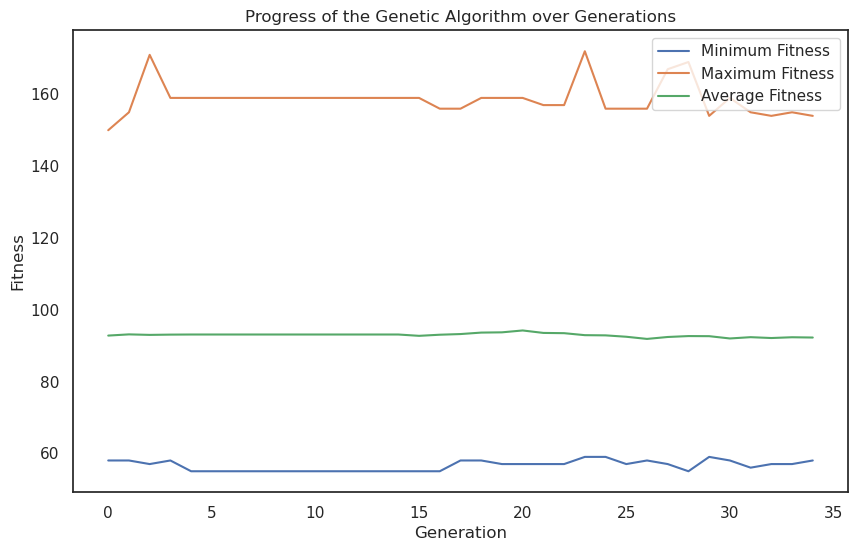

In [13]:
import matplotlib.pyplot as plt

# Extract data from the logbook
min_fitness_values = logbook.select('min')
max_fitness_values = logbook.select('max')
avg_fitness_values = logbook.select('avg')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(min_fitness_values, label='Minimum Fitness')
plt.plot(max_fitness_values, label='Maximum Fitness')
plt.plot(avg_fitness_values, label='Average Fitness')

# Customize the plot
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Progress of the Genetic Algorithm over Generations')
plt.legend(loc='upper right')

# Show the plot
plt.show()

# ***Create, train and test the optimized decision tree***

In [14]:
# Train and evaluate the decision tree with the best feature mask
mask = np.array(best_individual, dtype=bool)
ODt = DecisionTreeClassifier()
ODt.fit(train_features_scaled[:, mask], model_predictions.numpy())
train_accuracy = accuracy_score(train_labels, ODt.predict(train_features_scaled[:, mask]))
test_accuracy = accuracy_score(test_labels, ODt.predict(test_features_scaled[:, mask]))

# Calculate the number of branches for the best individual
n_leaf_nodes = ODt.tree_.n_leaves
n_branches = n_leaf_nodes - 1

print(f"Best individual: {best_individual}")
print(f"Number of selected features: {sum(best_individual)}")
print(f"Max tree depth: {ODt.tree_.max_depth}")
print(f"Number of branches: {n_branches}")
print(f"Train accuracy: {train_accuracy * 100:.2f}%, Test accuracy: {test_accuracy * 100:.2f}%")


Best individual: [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Number of selected features: 30
Max tree depth: 11
Number of branches: 43
Train accuracy: 75.12%, Test accuracy: 68.00%


# ***Plot the confusion matrix for the optimized decision tree***

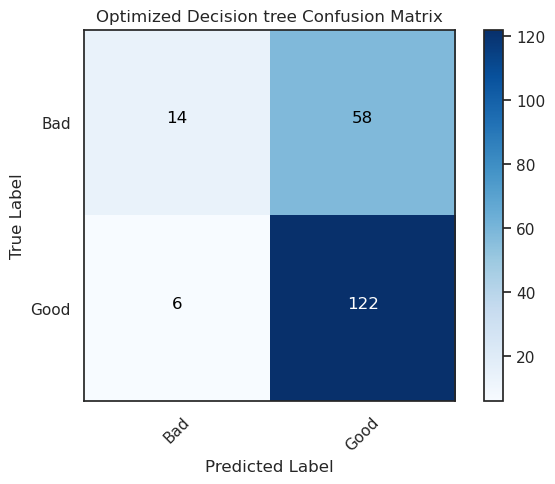

In [15]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
# Calculate the confusion matrix
test_predictions_unoptimized = ODt.predict(test_features_scaled[:, mask])
cm_unoptimized = confusion_matrix(test_labels, test_predictions_unoptimized)

# Plot the confusion matrix
sns.set(style="white")
plt.figure()
plt.imshow(cm_unoptimized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Optimized Decision tree Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Bad', 'Good'], rotation=45)
plt.yticks(tick_marks, ['Bad', 'Good'])

import itertools
for i, j in itertools.product(range(cm_unoptimized.shape[0]), range(cm_unoptimized.shape[1])):
    plt.text(j, i, cm_unoptimized[i, j], horizontalalignment="center", color="white" if cm_unoptimized[i, j] > cm_unoptimized.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# ***Plot a bar chart to compare the accuracy of the unoptimized decision tree and the optimized decision tree***

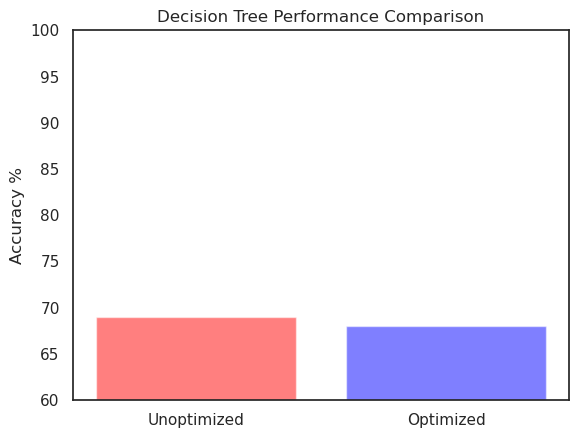

In [16]:
# Define the data
objects = ('Unoptimized', 'Optimized')
y_pos = np.arange(len(objects))
performance = [ test_accuracy_unoptimized * 100,  test_accuracy * 100]

# Create the bar chart
plt.figure()
plt.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue'])
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy %')
plt.title('Decision Tree Performance Comparison')
plt.ylim(60, 100)

# Show the bar chart
plt.show()

# ***Save the variables of the run to a csv file***

In [17]:
# Gather the data to save
details = [
    ("Batch Size", batch_size),
    ("Neural network Num epochs", num_epochs),
    ("Neural network Test Accuracy", f"{test_accuracy_nn * 100:.2f}%"),
    ("Number of Generations", generations),
    ("Population", population),
    ("Number of Selected Features", sum(best_individual)),
    ("Max Tree Depth", ODt.tree_.max_depth),
    ("Number of Branches", n_branches),
    ("GA OPT DT Train Accuracy", f"{train_accuracy * 100:.2f}%"),
    ("GA OPT DT Test Accuracy", f"{test_accuracy * 100:.2f}%"),
    ("Unoptimized Tree Max Depth", UDt.tree_.max_depth),
    ("Unoptimized Tree Number of Branches", UDt.tree_.n_leaves - 1),
    ("Unoptimized Tree Train Accuracy", f"{train_accuracy_unoptimized * 100:.2f}%"),
    ("Unoptimized Tree Test Accuracy", f"{test_accuracy_unoptimized * 100:.2f}%"),
]

# Save the data to a CSV file
with open("results.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Parameter", "Value"])
    for row in details:
        csv_writer.writerow(row)


# ***Save the plots of the decision trees and the decision trees with the classifiaction path for a row highlighted***
***Change which row by changing the "row" variable to the row number***

In [18]:
# Choose row to show example path
row = 5

def get_decision_path(clf, features):
    tree = clf.tree_
    node = 0
    decision_path = []

    while tree.children_left[node] != tree.children_right[node]:
        decision_path.append(node)
        if features[tree.feature[node]] <= tree.threshold[node]:
            node = tree.children_left[node]
        else:
            node = tree.children_right[node]
    
    decision_path.append(node)  # Add the leaf node to the path
    return decision_path

def visualize_tree(clf, feature_names, class_names, decision_path=None, filename=None):
    dot_data = export_graphviz(
        clf, out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True,
        special_characters=True
    )
    
    graph = Digraph(filename = filename)
    tree = clf.tree_
    tree_nodes = tree.node_count
    decision_path = set() if decision_path is None else set(decision_path)

    # Build the decision tree graph
    for node in range(tree_nodes):
        if tree.children_left[node] != tree.children_right[node]:
            label = f'{feature_names[tree.feature[node]]} <= {tree.threshold[node]:.2f}'
            graph.node(str(node), label=label, shape='box', color='red' if node in decision_path else 'black', penwidth='3' if node in decision_path else '1')
            if tree.children_left[node] != -1:
                graph.edge(str(node), str(tree.children_left[node]), label='True', color='red' if tree.children_left[node] in decision_path else 'black', penwidth='3' if tree.children_left[node] in decision_path else '1')
            if tree.children_right[node] != -1:
                graph.edge(str(node), str(tree.children_right[node]), label='False', color='red' if tree.children_right[node] in decision_path else 'black', penwidth='3' if tree.children_right[node] in decision_path else '1')
        else:
            label = f'{class_names[np.argmax(tree.value[node])]}'
            graph.node(str(node), label=label, shape='ellipse', color='red' if node in decision_path else 'black', penwidth='3' if node in decision_path else '1')

    return graph

# Use one row of the Cancer dataset
credit_row = train_features_scaled[row]  # or any other index

# Get the leaf node ID and decision path for the cancer row
node_id = ODt.tree_.apply(np.array([credit_row], dtype=np.float32))[0]
decision_path = get_decision_path(ODt, credit_row)

selected_feature_names = [name for name, mask in zip(data.columns[1:], best_individual) if mask]

# Visualize the optimised decision tree with the path highlighted
class_names = ['Bad', 'Good']
graph = visualize_tree(ODt, selected_feature_names, class_names, decision_path=decision_path, filename='Optimised_path')
graph.view()

# Visualize the optimised decision tree
graph = visualize_tree(ODt, selected_feature_names, class_names, filename='Optimised_tree')
graph.view()

# Visualize the unoptimised decision tree with the path highlighted
feature_names = data.columns[1:]
decision_path = get_decision_path(UDt, credit_row)
graph = visualize_tree(UDt, feature_names, class_names, decision_path=decision_path, filename='Unoptimised_path')
graph.view()

# Visualize the unoptimised decision tree
graph = visualize_tree(UDt, feature_names, class_names, filename='Unoptimised_tree')
graph.view()

Error: no "view" mailcap rules found for type "application/pdf"
Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'Optimised_path.pdf'
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'Optimised_tree.pdf'
Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin

'Unoptimised_tree.pdf'